# Пример поиска и распознавания объектов на изображении

Используется [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). Инструкции по установке:
- [Linux](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md).
- [Windows](https://medium.com/@rohitrpatil/how-to-use-tensorflow-object-detection-api-on-windows-102ec8097699).

Видео на YouTube с [демонстрацией распознавания объектов](https://youtu.be/1KzKqxx-s-Q).

In [18]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util
%matplotlib inline

## Загружаем модель TensorFlow

Модель можно загрузить из [Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Из каталога с моделью нужен всего один файл - frozen_inference_graph.pb. Это "замороженная" предварительно обученная сеть, которую можно использовать для распознавания (inference).

Есть два типа моделей, отличаются выходными данными, указано в слобце Outputs в таблице:
- Boxes - модель выдает прямоугольник, внутри которого находится найденный объект
- Masks - модель выдает маску пикселей, которые соответствуют объекту

In [19]:
# Тип выходных данных модели - Boxes
model_file_name = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/frozen_inference_graph.pb'
# Тип выходных данных модели - Masks
# model_file_name = 'mask_rcnn_resnet101_atrous_coco_2018_01_28/frozen_inference_graph.pb'

In [10]:
# Загружаем предварительно обученную модель в память
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(model_file_name, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Загружаем метки классов

Метки классов из набра данных [Common Objects in Context](http://cocodataset.org), 90 классов объектов.
Файлы с метками классов для разных наборов данных находятся в [репозитории моделей TensorFlow](https://github.com/tensorflow/models/tree/master/research/object_detection/data).

In [11]:
label_map = label_map_util.load_labelmap('data/mscoco_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [12]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Загружаем изображение и преобразуем его в массив

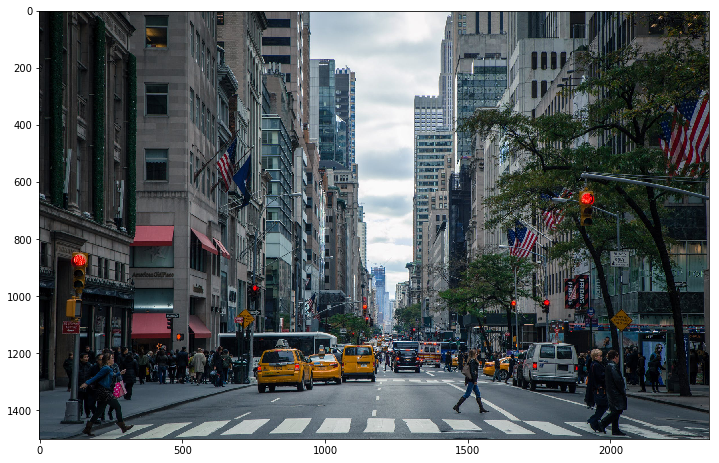

In [13]:
image_file_name = 'street.jpeg'
image = Image.open(image_file_name)
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
plt.figure(figsize=(12, 8))
plt.imshow(image_np)

Добавляем размерность к изображению

In [14]:
image_np_expanded = np.expand_dims(image_np, axis=0)

## Запускаем поиск объектов на изображении

In [15]:
with detection_graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Запуск поиска объектов на изображении
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image_np, 0)})

      # Преобразуем выходные тензоры типа float32 в нужный формат
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]

## Визуализируем результаты распознавания

Выводится исходная картинка, на ней найденные объекты выделяются прямоугольниками. Рядом с каждым пряоугольником написано название класса объекта и вероятность, с которой объект относится к этому классу.

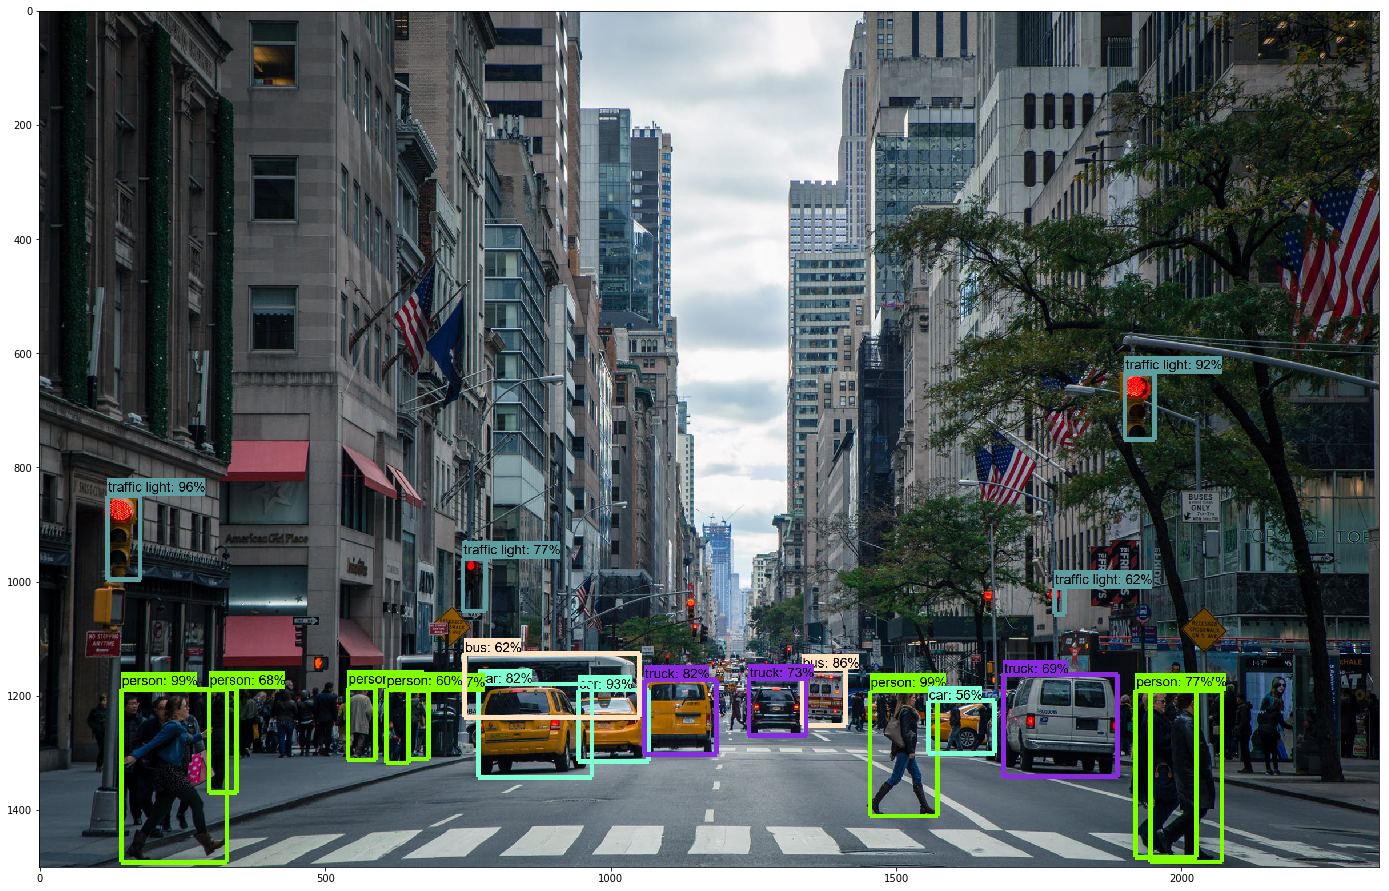

In [16]:
vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
plt.figure(figsize=(24, 16))
plt.imshow(image_np)